<a href="https://colab.research.google.com/github/manishaa-7/image-caption-generator/blob/main/Image_Caption_Generator_using_Deep_Learning(VGG19).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flickr8k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F623289%2F1111676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240405%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240405T073611Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2080ab2afb81d8c8a7f43e1cc72ef35e4abaa21892811732385f3ce01575338fcb12017e21084da804fc5c4daf3a8705eb975d66afa260cadf809ec1dbba031c903ebf3b99909ddb81e8735c00c7a129dbc5926f36c335f25f363ea110dced4daaf3abd99660f018a0330fb2623ed768242a1b4b337c677750157e736dbcf8072e7c464bda885f23f7b506fd7d23de769a9301451e2ba55977d54cbb8e101f10d82d6f18974c40e232e87b718ad88ac39e6b45285b03f854705aa6343dfb6f264a515cb81c51481ba2b3001a91e68aeb9872551797c77a29d7012de63b57780b2c6f06b302cf606e54d5f03fcf14add11d4b0c7da67a70b9d89ddb167b3256fa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1112971163 bytes downloaded
Downloaded and uncompressed: flickr8k
Data source import complete.


# Image Caption Project

# 1. Import Modules

In [ ]:
import os
import numpy as np
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# 2. Extract Features from the Image

In [ ]:
model = VGG19()

574710816/574710816 [==============================] - 3s 0us/step


In [ ]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

In [ ]:
for img_name in tqdm(os.listdir(directory)):

    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))

    # convert image pixels to numpy array
    image = img_to_array(image)

    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # preprocess image for vgg
    image = preprocess_input(image)

    # extract features
    feature = model.predict(image, verbose=0)

    # get image ID
    image_id = img_name.split('.')[0]

    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
import pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, '/kaggle/working/features.pkl'), 'rb') as f:
    features = pickle.load(f)

# 3. Load the Captions Data

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):

    # split the line by comma(,)
    tokens = line.split(',')

    if len(line) < 2:
        continue

    image_id, caption = tokens[0], tokens[1:]

    # remove extension from image ID
    image_id = image_id.split('.')[0]

    # convert caption list to string
    caption = " ".join(caption)

    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []

    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

# 4. Text Data Preprocessing

In [ ]:
def clean(mapping):

    for key, captions in mapping.items():

        for i in range(len(captions)):

            # take one caption at a time
            caption = captions[i]

            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()

            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')

            # delete additional spaces
            caption = caption.replace('\s+', ' ')

            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# 5. Train Test Split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0

    while 1:
        for key in data_keys:

            n += 1
            captions = mapping[key]

            # process each caption
            for caption in captions:

                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]

                # split the sequence into X, y pairs
                for i in range(1, len(seq)):

                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]

                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# 6. Model Building

In [ ]:
# Encoder - Contextual representation

# image feature layers
inputs1 = Input(shape=(4096,))

fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))

se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder - Generates o/p
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)

# output
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

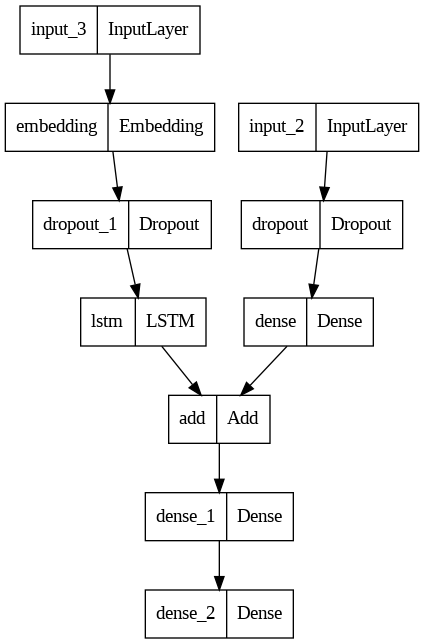

In [ ]:
plot_model(model)

In [ ]:
# train the model
epochs = 5
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):

    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 54s 237ms/step - loss: 3.1206


In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

# 7. Generating Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):

    # add start tag for generation process
    in_text = 'startseq'

    # iterate over the max length of sequence
    for i in range(max_length):

        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        # pad the sequence
        sequence = pad_sequences([sequence], max_length)

        # predict next word
        yhat = model.predict([image, sequence], verbose=0)

        # get index with high probability
        yhat = np.argmax(yhat)

        # convert index to word
        word = idx_to_word(yhat, tokenizer)

        # stop if word not found
        if word is None:
            break

        # append word as input for generating next word
        in_text += " " + word

        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):

    # get actual caption
    captions = mapping[key]

    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    # append to the list
    actual.append(actual_captions)

    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU: 0.552239


# 8. Visualizing the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):

    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('=============================== Actual ===============================')
    for caption in captions:
        print(caption)

    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('      ')
    print('============================== Predicted ==============================')
    print(y_pred)
    plt.imshow(image)

In [ ]:
#test

=============================== Actual ===============================
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
      
============================== Predicted ==============================
startseq two children are playing on ride ride endseq


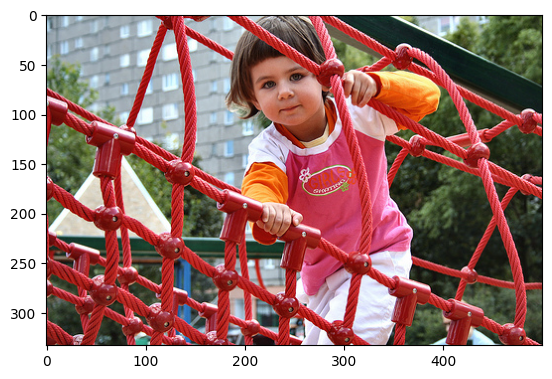

In [ ]:
generate_caption("1007320043_627395c3d8.jpg")

=============================== Actual ===============================
startseq man and baby are in yellow kayak on water endseq
startseq man and little boy in blue life jackets are rowing yellow canoe endseq
startseq man and child kayak through gentle waters endseq
startseq man and young boy ride in yellow kayak endseq
startseq man and child in yellow kayak endseq
      
============================== Predicted ==============================
startseq two men are in rowboat endseq


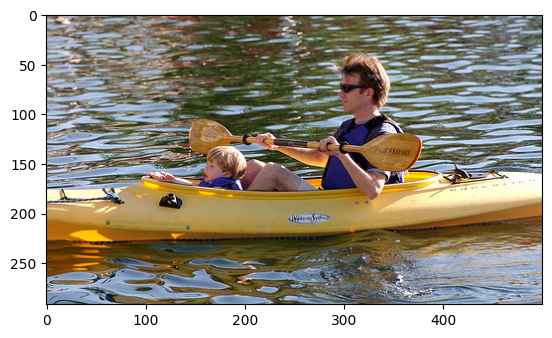

In [ ]:
generate_caption("1028205764_7e8df9a2ea.jpg")

=============================== Actual ===============================
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
      
============================== Predicted ==============================
startseq two people are walking down snowy hill endseq


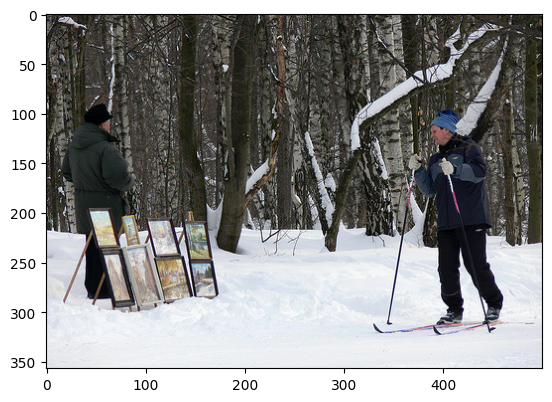

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

=============================== Actual ===============================
startseq dog prepares to catch thrown object in field with nearby cars endseq
startseq white dog is about to catch yellow ball in its mouth endseq
startseq white dog is about to catch yellow dog toy endseq
startseq white dog is ready to catch yellow ball flying through the air endseq
startseq white dog running after yellow ball endseq
      
============================== Predicted ==============================
startseq white dog is running through the grass endseq


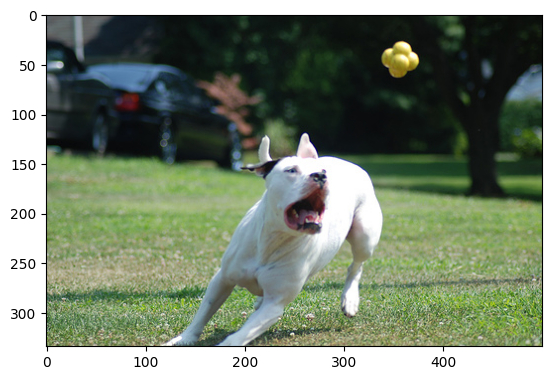

In [ ]:
generate_caption("1019604187_d087bf9a5f.jpg")

=============================== Actual ===============================
startseq woman is sitting on sidewalk with cellphone at her ear endseq
startseq woman rests on the curb of city street while talking on her cellphone endseq
startseq woman sits on the curb while talking on her cellphone endseq
startseq woman sits on the edge of sidewalk with garbage bin beside her endseq
startseq woman sits on the curb talking on cellphone endseq
      
============================== Predicted ==============================
startseq man in green shirt is jumping into the air endseq


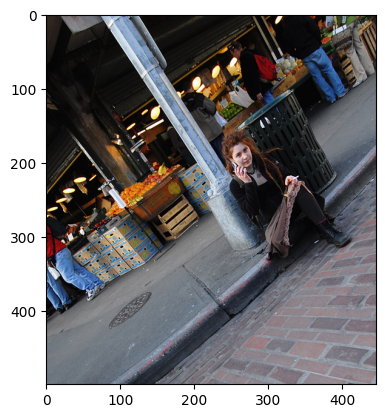

In [ ]:
generate_caption("437404867_209625774d.jpg")